In [8]:
from netCDF4 import Dataset, num2date, date2num
from libtiff import TIFF
import os, sys
import numpy as np

from datetime import datetime
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.animation import FuncAnimation
# import cartopy.crs as ccrs
from matplotlib import cm
# from mpl_toolkits.basemap import Basemap
import warnings




levels = {}
levels["hour"]  = [0., 0.2,   1,   5,  10,  20,  30,   40,   60,   80,  100,  150]
levels["day"]   = [0., 0.2,  5, 10,  20,  30,  40,  60,  100,  150,  200,  300]
levels["week"]  = [0., 0.2,  10,  20,  30,  50, 100,  150,  200,  300,  500, 1000]
levels["month"] = [0.,  10,  20,  30,  40,  50, 100,  200,  300,  500, 1000, 1500]
levels["year"]  = [0.,  50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 5000]
levels["psl"]  = [9000, 100000,  100100, 100300,  100500,  100700,  100900,  101000,  101200,  101400,  101600,  101800]

levels["zg"]=[1400, 1411, 1422, 1433, 1444, 1455, 1466, 1477, 1488, 1499, 1510, 1521]



prcp_colours_0 = [
                   "#FFFFFF", 
                   '#ffffd9',
                   '#edf8b1',
                   '#c7e9b4',
                   '#7fcdbb',
                   '#41b6c4',
                   '#1d91c0',
                   '#225ea8',
                   '#253494',
                   '#081d58',
                   "#4B0082"]

prcp_colours = [
                   "#FFFFFF", 
                   '#edf8b1',
                   '#c7e9b4',
                   '#7fcdbb',
                   '#41b6c4',
                   '#1d91c0',
                   '#225ea8',
                   '#253494',
                   '#4B0082',
                   "#800080",
                   '#8B0000']

prcp_colormap = matplotlib.colors.ListedColormap(prcp_colours)


def read_barra_data_fc(root_dir,date_time):
    filename=root_dir+date_time.strftime("%Y%m%d")+".nc"
    data = Dataset(filename, 'r')
#     print(data)# lat(324), lon(432)
    var = data["barra"][:]
    data.close()
    return var

def read_barra_data_fc_get_lat_lon(root_dir,date_time):
    filename=root_dir+date_time.strftime("%Y%m%d")+".nc"
    data = Dataset(filename, 'r')
    lats = data['lat'][:]
    lons = data['lon'][:]
    var = data["barra"][:]
    data.close()
    return var,lats,lons

def read_access_data(root_dir,en,date_time,leading,var_name="pr"):
    filename=root_dir+var_name+"/daily/"+en+"/"+"da_"+var_name+"_"+date_time.strftime("%Y%m%d")+"_"+en+".nc"
    data = Dataset(filename, 'r')
    var = data[var_name][leading]
    data.close()
    return var

def read_access_data_get_lat_lon(root_dir,en,date_time,leading,var_name="pr"):
    filename=root_dir+var_name+"/daily/"+en+"/"+"da_"+var_name+"_"+date_time.strftime("%Y%m%d")+"_"+en+".nc"
    data = Dataset(filename, 'r')
    var = data[var_name][leading]
    lats = data['lat'][:]
    lons = data['lon'][:]
    data.close()
    return var,lats,lons

def read_dem(filename):
    tif = TIFF.open(filename,mode='r')
    stack = []
    for img in list(tif.iter_images()):
        stack.append(img)
        
    dem_np=np.array(stack)
    dem_np=dem_np.transpose(1,2,0)
    return dem_np

def add_lat_lon(data,domain=[112.9, 154.00, -43.7425, -9.0],xarray=True):
    "data: is the something you want to add lat and lon, with first demenstion is lat,second dimention is lon,domain is DEM domain "
    new_lon=np.linspace(domain[0],domain[1],data.shape[1])
    new_lat=np.linspace(domain[2],domain[3],data.shape[0])
    if xarray:
        return xr.DataArray(data[:,:,0],coords=[new_lat,new_lon],dims=["lat","lon"])
    else:
        return data,new_lat,new_lon


def draw_aus(var,lat,lon,domain = [112.9, 154.25, -43.7425, -9.0], level="day" ,titles_on = True, title = "BARRA-R precipitation", colormap = prcp_colormap, cmap_label = "Precipitation (mm)",save=False,path=""):
    """ basema_ploting .py
This function takes a 2D data set of a variable from BARRA and maps the data on miller projection. 
The map default span is longitude between 111E and 155E, and the span for latitudes is -45 to -30, this is SE Australia. 
The colour scale is YlGnBu at 11 levels. 
The levels specifed are suitable for annual rainfall totals for SE Australia. 
From the BARRA average netCDF, the mean prcp should be multiplied by 24*365
"""
#    lats.sort() #this doesn't do anything for BARRA
#    lons.sort() #this doesn't do anything for BARRA
#     domain = [111.975, 156.275, -44.525, -9.975]#awap
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from mpl_toolkits.basemap import Basemap
    fig=plt.figure()
    level=levels[level]
    map = Basemap(projection = "mill", llcrnrlon = domain[0], llcrnrlat = domain[2], urcrnrlon = domain[1], urcrnrlat = domain[3], resolution = 'l')
    map.drawcoastlines()
    map.drawmapboundary()
    map.drawparallels(np.arange(-90., 120., 5.),labels=[1,0,0,0])
    map.drawmeridians(np.arange(-180.,180., 5.),labels=[0,0,0,1])
    llons, llats = np.meshgrid(lon, lat) # 将维度按照 x,y 横向竖向
#     print(lon.shape,llons.shape)
    x,y = map(llons,llats)
#     print(x.shape,y.shape)
    
    norm = BoundaryNorm(level, len(level)-1)
    data=xr.DataArray(var,coords=[lat,lon],dims=["lat","lon"])
    cs = map.pcolormesh(x, y, data, norm = norm, cmap = colormap) 

    
    if titles_on:
        # label with title, latitude, longitude, and colormap
        
        plt.title(title)
        plt.xlabel("\n\nLongitude")
        plt.ylabel("Latitude\n\n")
        cbar = plt.colorbar(ticks = level[:-1], shrink = 0.8, extend = "max")
        cbar.ax.set_ylabel(cmap_label)
        cbar.ax.set_xticklabels(level)
    if save:
        plt.savefig(path)
    else:
        plt.show()
    plt.cla()
    plt.close("all")
    return

In [ ]:
time=datetime(1990,1,9)
a=read_access_data('../data/',"e01",time,1)
a.shape

In [ ]:
var,lat,lon=read_barra_data_fc('../data/barra_aus/',time)
draw_aus(var,lat,lon)

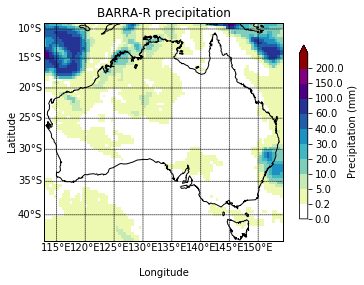

In [10]:
time=datetime(1990,1,25)
var,lat,lon=add_lat_lon(read_access_data('../data/','e01',time,0),domain=[112.9, 154.25, -43.7425, -9.0],xarray=False)
# var
draw_aus(var,lat,lon)

In [ ]:
a=read_dem("../DEM/"+"dem-9s1.tif")

In [3]:
var*80000
# lat.shape


masked_array(
  data=[[ 6.05971718e+04,  6.47547007e+04,  7.03082943e+04, ...,
          3.81059423e+02,  5.47287501e+02,  7.22923279e+02],
        [ 7.05782366e+04,  8.70168781e+04,  1.08066683e+05, ...,
          9.93165374e+01,  1.55168157e+02,  2.13284623e+02],
        [ 8.06781101e+04,  9.12001038e+04,  1.04151754e+05, ...,
         -2.06072237e+02, -1.45042539e+02, -8.92982911e+01],
        ...,
        [ 3.42247559e+06,  3.07372955e+06,  2.68714447e+06, ...,
          1.29699722e+06,  1.03512749e+06,  8.46038818e+05],
        [ 2.78957245e+06,  2.51106628e+06,  2.15538254e+06, ...,
          1.56705795e+06,  1.22845367e+06,  9.82564774e+05],
        [ 2.05641235e+06,  1.89276367e+06,  1.64195557e+06, ...,
          1.42568024e+06,  1.17672325e+06,  1.01499954e+06]],
  mask=False,
  fill_value=1e+20)